## Import necessary packages

In [1]:
# Add ../../ to path
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import sys

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

from cyclum import writer
from scPPR.periodic_inference import PeriodicInference
from scPPR.stage_classifier import StageClassifier
from scPPR.plot import plot_inference

## Read data

In [3]:
tpm = pd.read_csv('../data/H1_Fucci_GSE64016.csv', index_col=0).T
sttpm = np.log2(tpm + 1)
gene_df = sttpm.T
gene_df.columns = gene_df.columns.map(lambda x: x.split('_',1)[0])
gene_df

,G2,G2,G2,G2,G2,G2,G2,G2,G2,G2,...,G1,G1,G1,G1,G1,G1,G1,G1,G1,G1
MKL2,4.768658,3.061742,0.669632,3.395899,1.869176,7.058406,4.800791,0.000000,4.521207,9.176396,...,2.289135,6.415114,6.133254,1.088475,1.095810,0.000000,5.238090,3.611035,7.264845,6.954676
CD109,1.693580,2.826738,6.278492,1.008079,1.591043,3.567601,5.787955,7.373871,1.379430,2.945014,...,2.574520,3.037119,2.405950,3.108750,2.794283,1.925079,7.229429,1.927786,4.087180,3.013841
ABTB1,0.599205,0.000000,0.000000,1.501792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MAST2,0.599205,0.646503,6.094576,0.000000,4.636865,0.000000,6.016697,0.000000,0.000000,6.905067,...,0.979592,4.006247,0.000000,5.950248,4.569649,0.000000,0.782767,0.000000,2.720275,5.097195
KAT5,2.316155,0.656887,0.000000,8.407154,0.000000,0.000000,5.963652,1.923280,8.162049,0.000000,...,0.000000,6.600533,0.000000,0.000000,0.000000,0.000000,1.021629,5.809711,2.542510,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WDR33,9.054869,7.817036,8.432052,8.214736,8.250802,5.496059,6.931216,8.413260,7.357592,9.602228,...,7.553207,5.263448,6.998350,8.013481,3.442549,3.172872,8.214818,7.256010,9.470114,9.279227
EPSTI1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CLPTM1L,7.145296,5.681389,1.749607,7.271619,8.105135,8.057767,6.603514,6.248076,7.525124,5.212208,...,4.131130,7.618887,3.207464,7.299962,7.602485,5.955913,3.157803,0.000000,4.487246,4.495355
CCDC125,4.882074,5.625155,4.206341,3.688512,3.662965,5.087901,4.310960,4.741468,4.937533,3.908053,...,5.445248,4.713132,4.352736,4.918026,5.146314,5.094949,4.161985,5.248503,4.652413,5.056113


## SVD

In [4]:
def eigenexpression_fraction(sigma):
    sigma_power = np.power(sigma, 2)
    return sigma_power / np.sum(sigma_power)

def shannon_entropy(exp_fraction):
    return -1 / np.log(len(exp_fraction)) * np.sum(exp_fraction * np.log(exp_fraction))

U, sigma, VT = np.linalg.svd(gene_df, full_matrices=False)
exp_fraction = eigenexpression_fraction(sigma)
entropy = shannon_entropy(exp_fraction)
print(exp_fraction[:30], entropy)

[8.74212194e-01 3.09128150e-03 2.28722974e-03 1.17065178e-03
 1.06360805e-03 8.37813211e-04 8.11482033e-04 7.99434748e-04
 7.80922379e-04 7.75692793e-04 7.64800415e-04 7.58111127e-04
 7.54346187e-04 7.31351824e-04 7.26368115e-04 7.25168661e-04
 7.17785199e-04 7.09272743e-04 7.00983058e-04 6.91032312e-04
 6.87981117e-04 6.85932851e-04 6.82521600e-04 6.80793141e-04
 6.75517532e-04 6.72755539e-04 6.67308463e-04 6.61135566e-04
 6.55218171e-04 6.54112172e-04] 0.1927776694158041


In [5]:
# choose eigngene1,..., eigngene6
V = VT.T
V_scaled = preprocessing.scale(V)

data = V_scaled[:, 1:7]
N = 500
per_inf = PeriodicInference(N, N_iterations_MCMC = int(1e4), N_passes_optimisation=0)
ml_phases, ml_likelihood, samples_phase, samples_likelihood = per_inf.estimate_uncertainty(data)
# import pickle
# with open('../data/H1_Fucci_GSE64016.pickle', 'rb') as pickle_file:
#     save_variables = pickle.load(pickle_file)
#     ml_phases = save_variables["ml_phases"]
#     samples_phase = save_variables["samples_phase"]
#     ml_likelihood = save_variables["ml_likelihood"]
#     samples_likelihood = save_variables["samples_likeilhood"]

print(ml_phases[:,0])

individual_phases = per_inf.predict_phases(data, ml_phases[:,0])

phase_init:  [0.         3.63168111 2.82743339 5.45380485 1.97292019 1.75929189]
Optimise mcmc settings
phase_sigma_opt:  1.0
Run mcmc
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Accept Ratio: 0.3748
[0.         3.12902628 5.44123848 1.60849544 5.41610573 2.60123872]


## Plot

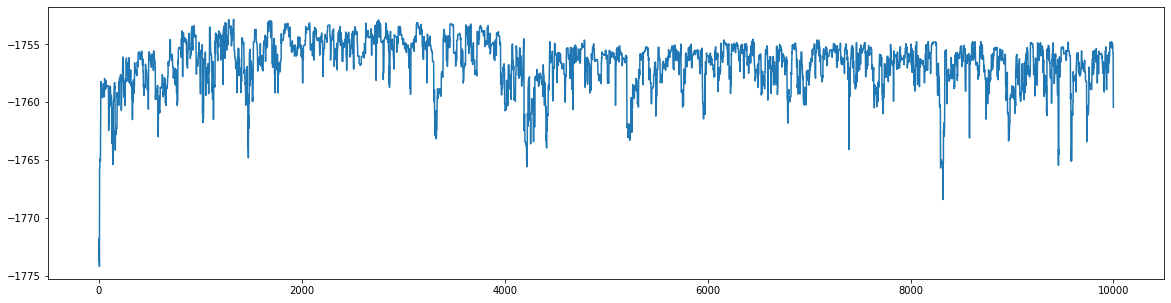

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(samples_likelihood)), samples_likelihood)
plt.show()

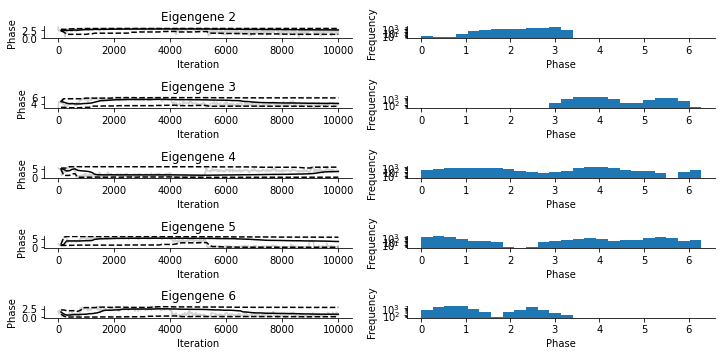

In [7]:
plot_inference(samples_phase)

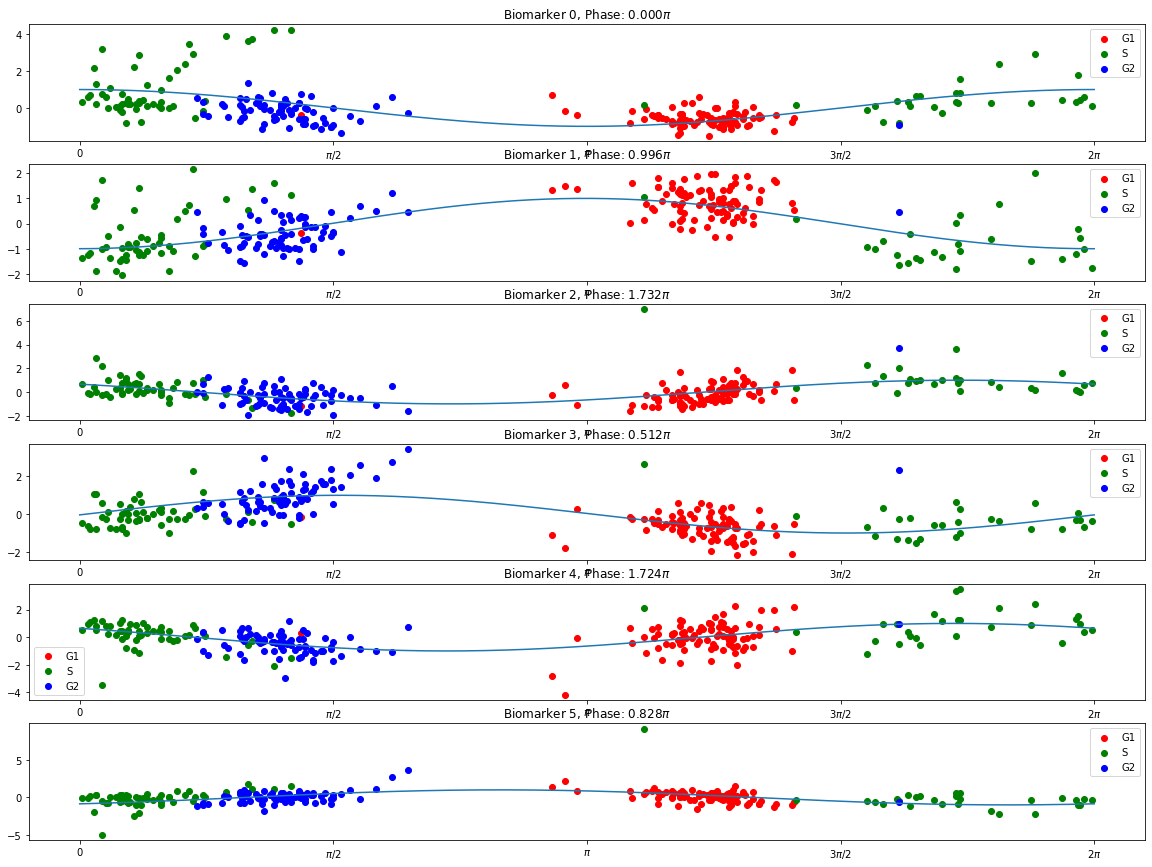

In [8]:
n_biomarkers = 6
plt.figure(figsize=(20, 15))
bins = np.linspace(0, 2 * np.pi, 1000)
tick_bins = np.linspace(0, 2 * np.pi, 5)
ticks = ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2', r'2$\pi$']
color_map = {'stage': {"G1": "red", "S": "green", "G2": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}

for i, phase in enumerate(ml_phases[:,0]):
    gt = np.cos(bins - phase)
    plt.subplot(n_biomarkers, 1, i+1)
    plt.plot(bins, gt)
    for l, c in color_map['stage'].items():
        index = gene_df.columns == l
        plt.scatter(individual_phases[index], data[index][:,i], label=l, color=c)
    plt.title('Biomarker {}, Phase: {:.3f}$\pi$'.format(i, phase/np.pi))
    plt.xticks(tick_bins, ticks, rotation=0)
    plt.tick_params(labelsize=10)
    plt.legend(loc='best')
plt.show()

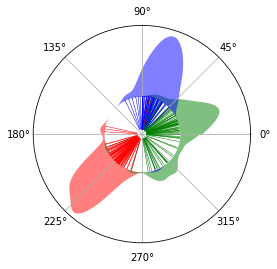

In [9]:
import cyclum.illustration
cyclum.illustration.plot_round_distr_color(individual_phases, gene_df.columns, color_map['stage'])
pass